In [133]:
import os
import numpy as np
import pandas as pd

In [134]:
dataset_name = 'mosad'
output_dir = f'./../../processed/{dataset_name}/'
os.makedirs(output_dir, exist_ok=True)
outp_fname = os.path.join(output_dir, f'{dataset_name}.csv')

In [135]:
def load_mosad_dataset():
    cp_filename = "./datasets/change_points.txt"
    cp_file = []

    with open(cp_filename, 'r') as file:
        for line in file.readlines(): cp_file.append(line.split(","))
        
    activity_filename = "./datasets/activities.txt"
    activities = dict()

    with open(activity_filename, 'r') as file:
        for line in file.readlines():
            line = line.split(",")
            routine, motions = line[0], line[1:]
            activities[routine] = [motion.replace("\n", "") for motion in motions]

    ts_filename = "./datasets/data.npz"
    T = np.load(file=ts_filename)

    df = []

    for row in cp_file:
        (ts_name, sample_rate), change_points = row[:2], row[2:]
        routine, subject, sensor = ts_name.split("_")
        ts = T[ts_name]

        df.append((ts_name, int(routine[-1]), int(subject[-1]), sensor, int(sample_rate), np.array([int(_) for _ in change_points]), np.array(activities[routine[-1]]), ts))

    return pd.DataFrame.from_records(df, columns=["dataset", "routine", "subject", "sensor", "sample_rate", "change_points", "activities", "time_series"])

In [136]:
df_mosad = load_mosad_dataset()
df_mosad

,dataset,routine,subject,sensor,sample_rate,change_points,activities,time_series
0,Routine1_Subject1_X-Acc,1,1,X-Acc,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.1986, -0.454326, -0.5473, -0.496056, -0.48..."
1,Routine1_Subject1_X-Gyro,1,1,X-Gyro,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[0.0174, 0.0358, 0.0431, 0.0358, 0.0168, 0.008..."
2,Routine1_Subject1_X-Mag,1,1,X-Mag,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-31.02, -30.84, -30.65, -30.58, -31.52, -30.7..."
3,Routine1_Subject1_Y-Acc,1,1,Y-Acc,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.0161, -0.100877, -0.1434, -0.13972, -0.081..."
4,Routine1_Subject1_Y-Gyro,1,1,Y-Gyro,50,"[738, 1722, 11356, 14124, 20558, 29858, 32736,...","[descend stairs, climb stairs, vacuum, lie, ir...","[-0.0525, -0.0568, -0.0482, -0.0012, 0.0153, 0..."
...,...,...,...,...,...,...,...,...
121,Routine3_Subject5_Y-Gyro,3,5,Y-Gyro,50,"[6056, 9160, 15209, 16735, 17785]","[slow walk, run, walk, rope jump, squat, jumpi...","[0.0923, 0.137903, 0.118283, 0.0465, -0.035871..."
122,Routine3_Subject5_Y-Mag,3,5,Y-Mag,50,"[6056, 9160, 15209, 16735, 17785]","[slow walk, run, walk, rope jump, squat, jumpi...","[187.01, 187.93, 187.78, 185.81, 185.66, 186.5..."
123,Routine3_Subject5_Z-Acc,3,5,Z-Acc,50,"[6056, 9160, 15209, 16735, 17785]","[slow walk, run, walk, rope jump, squat, jumpi...","[0.0949, 0.4038, 0.4038, 0.4038, 0.418, 0.418,..."
124,Routine3_Subject5_Z-Gyro,3,5,Z-Gyro,50,"[6056, 9160, 15209, 16735, 17785]","[slow walk, run, walk, rope jump, squat, jumpi...","[-0.1484, -0.128387, -0.098542, -0.0622, -0.04..."


In [137]:
grouped = df_mosad.groupby(['routine', 'subject'])

In [138]:
dfs = []
for name, group in grouped:
    experiment_data = {}
    for i, row in group.iterrows():
        sensor_name = row['sensor']
        experiment_data[sensor_name] = row['time_series']

    activities = row['activities']
    change_points = row['change_points']
    processed_activities = [np.nan for _ in range(len(row['time_series']))]
        
    processed_activities[0] = activities[0]
    for i, j in zip(change_points, activities[1:]):
        processed_activities[i] = j

    df = pd.DataFrame(experiment_data)
    df.insert(0, 'id', f"routine_{row['routine']}_subject_{row['subject']}")
    df.insert(1, 'time_step', range(len(df)))
    df.insert(2, 'routine', row['routine'])
    df.insert(3, 'subject', row['subject'])
    

    df['activities'] = processed_activities
        
    dfs.append(df)
        

In [139]:
data = pd.concat(dfs)
data

,id,time_step,routine,subject,X-Acc,X-Gyro,X-Mag,Y-Acc,Y-Gyro,Y-Mag,Z-Acc,Z-Gyro,Z-Mag,activities
0,routine_1_subject_1,0,1,1,-0.198600,0.0174,-31.020000,-0.016100,-0.0525,-127.260000,0.086500,0.0509,-78.800000,descend stairs
1,routine_1_subject_1,1,1,1,-0.454326,0.0358,-30.840000,-0.100877,-0.0568,-127.410000,0.106412,0.0851,-78.160000,NaN
2,routine_1_subject_1,2,1,1,-0.547300,0.0431,-30.650000,-0.143400,-0.0482,-127.860000,0.010700,0.1157,-78.930000,NaN
3,routine_1_subject_1,3,1,1,-0.496056,0.0358,-30.580000,-0.139720,-0.0012,-127.230000,-0.143706,0.1291,-79.720000,NaN
4,routine_1_subject_1,4,1,1,-0.480500,0.0168,-31.520000,-0.081900,0.0153,-127.270000,-0.200700,0.1193,-79.140000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19396,routine_3_subject_5,19396,3,5,0.443500,-0.0503,7.777608,-0.820100,-0.1455,-25.363487,-0.197300,-0.1785,-25.712826,NaN
19397,routine_3_subject_5,19397,3,5,0.547000,-0.0198,7.566146,0.739000,-0.1290,-25.310689,-0.197000,-0.2280,-25.725660,NaN
19398,routine_3_subject_5,19398,3,5,0.547000,0.0303,7.077993,0.739000,-0.1595,-25.325167,-0.197000,-0.2170,-25.778003,NaN
19399,routine_3_subject_5,19399,3,5,0.547000,0.0658,7.042792,0.739000,-0.2194,-25.728202,-0.197000,-0.1742,-24.757846,NaN


<Axes: xlabel='id'>

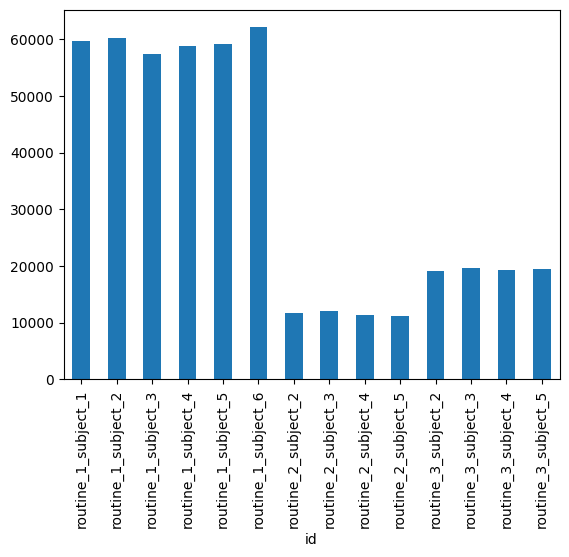

In [140]:
data['activities'] = data['activities'].ffill()
data['id'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='id'>

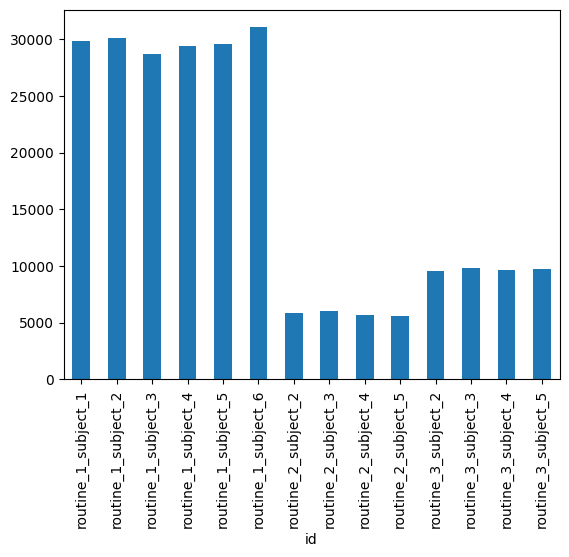

In [141]:
from statistics import mode
import math

def quantize_df(data: pd.DataFrame , id_col:str , steps: int):

    def aggregate_group(group, steps=steps):
        numeric_cols = group.select_dtypes(include=[np.number]).columns
        object_cols = group.select_dtypes(exclude=[np.number]).columns
        
        aggregation_functions = {col: 'mean' for col in numeric_cols}
        aggregation_functions.update({col: lambda x: mode(x) for col in object_cols})
        
        grouped = group.groupby(np.arange(len(group)) // steps).agg(aggregation_functions)
        grouped['time_step'] = range(len(grouped))
        return grouped

    dfs = []
    cols = list(data.columns.values)

    data_grouped = data.groupby(id_col)
    for name, group in data_grouped:
        aggregated_group = aggregate_group(group)
        dfs.append(aggregated_group)

    data_quantized = pd.concat(dfs).reset_index(drop=True)
    data_quantized = data_quantized[cols] #to keep the columns order
    return data_quantized


id_col = "id"
steps = 2

data_quantized = quantize_df(data,id_col,steps)
data_quantized[id_col].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='subject'>

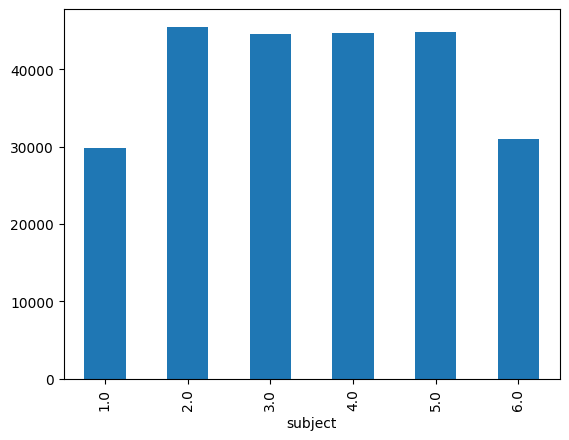

In [142]:
n_kFolds = 4
base_col ="subject"
data_quantized[base_col].value_counts().sort_index().plot(kind='bar')

In [143]:
n_base = data_quantized[base_col].nunique()
split_ratio = 0.8 # train
n_base_train = int(np.floor(n_base * split_ratio))
n_base_test = n_base - n_base_train
print("Max train series to select: ", n_base_train)
print("Max test series to select: ", n_base_test)

Max train series to select:  4
Max test series to select:  2


In [144]:
must_train_base=[]
must_test_base=[6]

n = n_base - len(must_train_base) - len(must_test_base)
k = n_base_test - len(must_test_base)

if n < n_kFolds or k < 1 :
    raise ValueError("You selected too many bases")

max_kFolds = math.comb(n,k)
if max_kFolds < n_kFolds:
    raise ValueError("Can't achieve the number of folds with current configuration")



In [145]:
#may need casting since we did average operation to quantize the dataframe
data_quantized[base_col] = data_quantized[base_col].astype(int)

base = list(data_quantized[base_col].unique())
base_pool = [b for b in base if b not in must_train_base]
base_pool = [b for b in base_pool if b not in must_test_base]



In [146]:
import random
import itertools


def create_unique_folds(data, k, n_kFolds, seed=42):
    random.seed(seed)
    unique_combinations = list(itertools.combinations(data, k))
    
    if len(unique_combinations) < n_kFolds:
        raise ValueError("Not enough unique combinations to create the required number of folds.")
    
    # Randomly sample k unique folds
    folds = random.sample(unique_combinations, n_kFolds)
    
    return folds



file_name = outp_fname.split('.csv')[0] 
folds = create_unique_folds(base_pool, k, n_kFolds)

for i, fold in enumerate(folds):
    test_base = must_test_base  + list(fold)

    dataset_name = f'mosad_fold_{i}'
    outp_folder = output_dir = f'./../../processed/{dataset_name}'
    os.makedirs(outp_folder, exist_ok=True)
    train_file_name = os.path.join(outp_folder, f'{dataset_name}_train.csv')
    test_file_name = os.path.join(outp_folder, f'{dataset_name}_test.csv')
    full_file_name = os.path.join(outp_folder, f'{dataset_name}.csv')
    test_key_file_name = os.path.join(outp_folder, f'{dataset_name}_test_key.csv')

    data_quantized_test = data_quantized[data_quantized[base_col].isin(test_base)].reset_index(drop=True)
    test_key = data_quantized_test[['id','time_step','routine','subject']]
    test_key['activities'] = data_quantized_test['activities']

    full_dataset = pd.concat([data_quantized_train, data_quantized_test])
    full_dataset.to_csv(full_file_name, index=False)

    data_quantized_test.drop(columns='activities', inplace=True)
    data_quantized_test.to_csv(test_file_name, index=False)

    data_quantized_train = data_quantized[~data_quantized[base_col].isin(test_base)].reset_index(drop=True)
    data_quantized_train.to_csv(train_file_name, index=False)

    test_key.to_csv(test_key_file_name, index=False)





/var/folders/v2/zm88qd750pz1379tn2s194q00000gn/T/ipykernel_66033/4182271029.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_key['activities'] = data_quantized_test['activities']
/var/folders/v2/zm88qd750pz1379tn2s194q00000gn/T/ipykernel_66033/4182271029.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_key['activities'] = data_quantized_test['activities']
/var/folders/v2/zm88qd750pz1379tn2s194q00000gn/T/ipykernel_66033/4182271029.py:35: SettingWithCopyWarning: 
A value is trying to be set 

In [147]:
file_name

'./../../processed/mosad/mosad'

In [148]:
data_quantized_train['activities'].unique()

array(['descend stairs', 'climb stairs', 'vacuum', 'lie', 'iron', 'mop',
       'sit', 'make bed', 'stand', 'slow walk', 'hang out laundry',
       'walk', 'fold laundry', 'spin', 'sit-ups', 'modified push-ups',
       'run', 'rope jump', 'squat', 'jumping jack'], dtype=object)

In [151]:
pd.read_csv('/Users/mo/Desktop/ReadyTensor/datasets/time-series-annot/datasets/processed/mosad_fold_0/mosad_fold_0.csv')

,id,time_step,routine,subject,X-Acc,X-Gyro,X-Mag,Y-Acc,Y-Gyro,Y-Mag,Z-Acc,Z-Gyro,Z-Mag,activities
0,routine_1_subject_1,0,1.0,1,-0.326463,0.026600,-30.930,-0.058488,-0.054650,-127.335,0.096456,0.068000,-78.480,descend stairs
1,routine_1_subject_1,1,1.0,1,-0.521678,0.039450,-30.615,-0.141560,-0.024700,-127.545,-0.066503,0.122400,-79.325,descend stairs
2,routine_1_subject_1,2,1.0,1,-0.527764,0.012550,-31.125,-0.039517,0.013750,-127.720,-0.235293,0.116900,-78.960,descend stairs
3,routine_1_subject_1,3,1.0,1,-0.096810,0.008900,-30.885,0.101166,0.062350,-127.170,-0.297958,0.086650,-79.265,descend stairs
4,routine_1_subject_1,4,1.0,1,-0.049340,0.022350,-30.505,0.024601,0.123700,-127.620,-0.083727,0.007550,-79.395,descend stairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224825,routine_1_subject_6,31050,1.0,6,-0.291800,0.294481,-11.450,-0.033900,-0.328903,41.700,0.046100,0.047479,-12.200,fold laundry
224826,routine_1_subject_6,31051,1.0,6,-0.400400,0.283656,-11.500,-0.306000,-0.289114,41.600,0.101000,0.037821,-12.200,fold laundry
224827,routine_1_subject_6,31052,1.0,6,-0.352250,0.213004,-11.550,-0.312950,-0.295972,41.500,0.128400,0.040941,-12.200,fold laundry
224828,routine_1_subject_6,31053,1.0,6,-0.284650,0.183460,-11.600,-0.144850,-0.292837,41.500,0.220050,0.026977,-12.200,fold laundry


In [152]:
data_quantized_test

,id,time_step,routine,subject,X-Acc,X-Gyro,X-Mag,Y-Acc,Y-Gyro,Y-Mag,Z-Acc,Z-Gyro,Z-Mag
0,routine_1_subject_2,0,1.0,2,0.021900,0.136850,-81.991202,0.011150,0.097000,13.130700,-0.561900,-0.055900,-15.344833
1,routine_1_subject_2,1,1.0,2,0.158200,0.139731,-81.960669,0.241100,0.104899,12.650073,-0.668250,-0.102146,-15.902090
2,routine_1_subject_2,2,1.0,2,-0.230050,0.085185,-81.944176,0.443450,0.121020,12.218462,-0.629950,-0.120743,-16.317715
3,routine_1_subject_2,3,1.0,2,-1.167650,0.101101,-81.928500,0.280950,0.064863,11.841500,0.040950,-0.067175,-16.670500
4,routine_1_subject_2,4,1.0,2,-0.888250,0.443935,-81.869777,-0.493850,0.193345,11.473795,1.444750,-0.054492,-17.203581
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76571,routine_3_subject_2,9533,3.0,2,0.050928,-1.002050,-14.856000,3.494687,2.148954,97.007500,-1.200435,1.019470,12.498000
76572,routine_3_subject_2,9534,3.0,2,2.380850,1.272750,-15.250000,4.679400,-1.882856,97.118500,2.690750,0.277657,12.705000
76573,routine_3_subject_2,9535,3.0,2,0.574300,1.336669,-16.133000,-1.227250,-1.033940,95.978000,1.948350,-0.225404,12.465500
76574,routine_3_subject_2,9536,3.0,2,0.183800,-0.191295,-16.503000,-0.786650,0.953795,95.531000,0.974300,-0.172839,12.323500
